<a href="https://colab.research.google.com/github/diegobarrera/kaggle-ML/blob/master/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sector Atención al Cliente

"Recibimos muchas consultas de clientes a través de correo electrónico y chat. Nos gustaría poder clasificar automáticamente estas consultas por tema o urgencia para poder responder de forma más rápida y eficiente. ¿Podría la IA ayudarnos a hacerlo?"

## Cómo nos enfrentamos a un proyecto de IA?
* **Escogemos una o varias tareas a resolver**:

 Dado un texto proveniente de un correo o chat, poder clasificar la urgencia y el tema del mismo.

 **Inicialmente se hara solo la clasificacion de la urgencia**.

* **Escogemos una librería de software**
 Limpieza det dataset con este ejemplo https://www.kaggle.com/code/haneenhossam/customer-support-twitter-preprocessing-modelling#Lemmatization

* **Creamos nuestro dataset etiquetado**:

 Idealmente el cliente podria proporcioinar ejemplos de los correos o chats, para poderlos etiquetar por **tema** y por **urgencia**.

 Dataset con labels https://huggingface.co/datasets/gorkemsevinc/customer_support_tickets

* **Escogemos n modelos**

  Debemos realizar dos clasificaciones, una para la urgencia y otra para el tema. Debido a que lo que debemos analizar es texto debemos hacer un encoding para poder crear un word embebbing y asi sea algo entendible para la maquina.
 * https://www.kaggle.com/code/yaminh/ticket-similarity-analysis-word2vec-faiss

* **Entrenamos**

* **Poner en marcha** (como quiere nuestro cliente que ejecutemos la solución)


In [6]:
import pandas as pd

df = pd.read_parquet("hf://datasets/gorkemsevinc/customer_support_tickets/data/train-00000-of-00001.parquet")

In [7]:
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [3]:
df.describe()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
count,8469,8469,8469,8469,8469,8469
unique,8320,42,5,16,8438,4
top,bsmith@example.com,canon eos,refund request,refund request,i'm having an issue with the google nest. plea...,medium
freq,4,240,1752,576,3,2192


In [4]:
df.isnull().sum()

,0
Customer Email,0
Product Purchased,0
Ticket Type,0
Ticket Subject,0
Combined Text,0
Ticket Priority,0


Dividir los datos de tests de los de train

20% - 80%

In [5]:
def preprocess(text):
    # Eliminar stop words, signos de puntuación, etc.
    # Puedes utilizar librerías como NLTK para un preprocesamiento más avanzado
    return text.lower()

df['Combined Text'] = df['Combined Text'].apply(preprocess)
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [6]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['text_to_punct'] = df['Combined Text'].apply(lambda text: remove_punctuation(text))
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority,text_to_punct
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical,im having an issue with the gopro hero please ...
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical,im having an issue with the lg smart tv please...
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low,im facing a problem with my dell xps the dell ...
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low,im having an issue with the microsoft office p...
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low,im having an issue with the autodesk autocad p...


In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_to_stop"] = df["text_to_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority,text_to_punct,text_to_stop
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical,im having an issue with the gopro hero please ...,im issue gopro hero please assist billing zip ...
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical,im having an issue with the lg smart tv please...,im issue lg smart tv please assist need change...
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low,im facing a problem with my dell xps the dell ...,im facing problem dell xps dell xps turning wo...
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low,im having an issue with the microsoft office p...,im issue microsoft office please assist proble...
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low,im having an issue with the autodesk autocad p...,im issue autodesk autocad please assist note s...


In [10]:
# from collections import Counter
# cnt = Counter() #returns a list of tuples containing the most common words and their respective word counts in descending order.
# for text in df["text_to_stop"].values:
#     for word in text.split():
#         cnt[word] += 1

# cnt.most_common(10)

[('issue', 11549),
 ('im', 10287),
 ('please', 8807),
 ('assist', 6250),
 ('ive', 6001),
 ('resolution', 5706),
 ('pending', 5705),
 ('product', 2290),
 ('problem', 2285),
 ('data', 1661)]

In [9]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
# Import the WordNet Lemmatizer
from nltk.stem import WordNetLemmatizer

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    """Custom function to lemmatize words in text"""

    # Split the input text into words
    words = text.split()

    # Initialize an empty list to store lemmatized words
    lemmatized_words = []

    # Iterate through the words in the input text
    for word in words:
        # Apply lemmatization to the word and add the lemmatized word to the list
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)

    # Join the lemmatized words into a single string with spaces in between
    lemmatized_text = " ".join(lemmatized_words)

    # Return the lemmatized text
    return lemmatized_text


df["text_to_stop"] = df["text_to_stop"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority,text_to_punct,text_to_stop
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical,im having an issue with the gopro hero please ...,im issue gopro hero please assist billing zip ...
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical,im having an issue with the lg smart tv please...,im issue lg smart tv please assist need change...
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low,im facing a problem with my dell xps the dell ...,im facing problem dell xps dell xps turning wo...
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low,im having an issue with the microsoft office p...,im issue microsoft office please assist proble...
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low,im having an issue with the autodesk autocad p...,im issue autodesk autocad please assist note s...


In [46]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # from 0 to test_set_size
    train_indices = shuffled_indices[test_set_size:] # from test_set_size to len(data)
    # return a tuple
    return data.iloc[train_indices], data.iloc[test_indices]

In [47]:
train_set, test_set = shuffle_and_split_data(df, 0.2)
print(len(train_set), len(test_set))

6776 1693


In [48]:
X_train = train_set['text_to_stop'].values
y_priority = train_set['Ticket Priority'].values
y_type = train_set['Ticket Type'].values

# test
x_test = test_set['text_to_stop'].values
y_test_priority = test_set['Ticket Priority'].values
y_test_type = test_set['Ticket Type'].values
# df_priority = df.drop(['Customer Email', 'Product Purchased', 'Ticket Subject', 'Ticket Type'], axis=1)

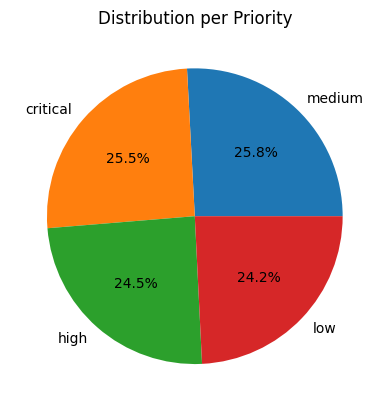

In [49]:
import matplotlib.pyplot as plt


priority_count = train_set["Ticket Priority"].value_counts()

plt.title('Distribution per Priority')
plt.pie(priority_count, labels=priority_count.index, autopct='%1.1f%%')
plt.show()



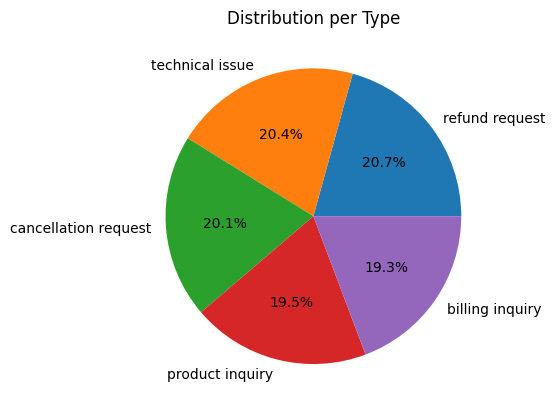

In [50]:

type_count = train_set["Ticket Type"].value_counts()

plt.title('Distribution per Type')
plt.pie(type_count, labels=type_count.index, autopct='%1.1f%%')
plt.show()

## Approach #1: Random Forest Classifier

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [52]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(X_train)

In [53]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X, y_priority)

RandomForestClassifier()

In [54]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_rf.predict(X_test)
# print(X_train)
# print(X_test)

In [20]:
fake_comment = ["This product is broken I want a refund"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

In [21]:
fake_comment = ["exactly what I expected, the product is amazing!"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

### Evaluar el accuracy

In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy RandomForestClassifier:", accuracy)

Accuracy RandomForestClassifier: 0.2640283520378027


## Approach #2 - Support Vector Machine

In [23]:
from sklearn.svm import SVC

model_SVM = SVC()
model_SVM.fit(X, y_priority)

SVC()

In [24]:
y_priority_pred = model_SVM.predict(X_test)

In [25]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy SVM:", accuracy)

Accuracy SVM: 0.24630832841110456


In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


# vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)

model_nb = MultinomialNB()
model_nb.fit(X, y_priority)

MultinomialNB()

In [27]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_nb.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy Naive Bayes:", accuracy)

Accuracy Naive Bayes: 0.2279976373301831


## BERT Model

In [29]:
priority_mapping = {label: idx for idx, label in enumerate(df['Ticket Priority'].unique())}
df['Priority Label'] = df['Ticket Priority'].map(priority_mapping)
print("Priority Label Column Exists:", 'Priority Label' in df.columns)



Priority Label Column Exists: True


In [30]:
train_set, test_set = shuffle_and_split_data(df, 0.2)

X_train = train_set['text_to_stop'].astype(str).tolist()  # Ensure texts are strings
y_train_priority = train_set['Priority Label'].values
X_test = test_set['text_to_stop'].astype(str).tolist()  # Ensure texts are strings
y_test_priority = test_set['Priority Label'].values

In [31]:
train_set['text_to_stop'].head()

,text_to_stop
7804,im issue nest thermostat please assist httpsco...
2898,gopro hero unable establish stable internet co...
4151,im issue bose quietcomfort please assist possi...
3637,dyson vacuum cleaner making strange noises fun...
915,im issue canon dslr camera please assist small...


In [32]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(priority_mapping)
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
def encode_texts(texts, tokenizer):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=128)


In [34]:
train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)


In [35]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_priority
)).shuffle(len(X_train)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_priority
)).batch(32)

In [36]:
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])


In [37]:
bert_model.fit(train_dataset, validation_data=test_dataset, epochs=5)


Epoch 1/5
212/212 [==============================] - 130s 397ms/step - loss: 1.4347 - accuracy: 0.2453 - val_loss: 1.4086 - val_accuracy: 0.2534
Epoch 2/5
212/212 [==============================] - 83s 393ms/step - loss: 1.4405 - accuracy: 0.2484 - val_loss: 1.4301 - val_accuracy: 0.2522
Epoch 3/5
212/212 [==============================] - 86s 405ms/step - loss: 1.4300 - accuracy: 0.2444 - val_loss: 1.4170 - val_accuracy: 0.2534
Epoch 4/5
212/212 [==============================] - 86s 406ms/step - loss: 1.4329 - accuracy: 0.2516 - val_loss: 1.4872 - val_accuracy: 0.2534
Epoch 5/5
212/212 [==============================] - 86s 403ms/step - loss: 1.4514 - accuracy: 0.2426 - val_loss: 1.4070 - val_accuracy: 0.2534


In [38]:
loss, accuracy = bert_model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy}")

53/53 [==============================] - 9s 164ms/step - loss: 1.4070 - accuracy: 0.2534
Test Accuracy: 0.25339633226394653


In [39]:
y_priority_pred_logits = bert_model.predict(test_encodings)['logits']
y_priority_pred_classes = np.argmax(y_priority_pred_logits, axis=1)

# Calculate accuracy score using sklearn
accuracy = accuracy_score(y_test_priority, y_priority_pred_classes)
print("Test Accuracy:", accuracy)

53/53 [==============================] - 12s 159ms/step
Test Accuracy: 0.25339633786178384


In [40]:
df['Priority Label'].value_counts()

,count
Priority Label,
3,2192
0,2129
2,2085
1,2063


In [13]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load the data
data = pd.read_parquet("hf://datasets/gorkemsevinc/customer_support_tickets/data/train-00000-of-00001.parquet")

# Combine relevant text features
data['Combined Text'] = data['Combined Text'] + ' ' + data['Ticket Subject']

# Preprocess the text data
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(data["Combined Text"])

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output to False for dense output
product_purchased_encoded = encoder.fit_transform(data[['Product Purchased']])

# Combine numerical and categorical features
X = np.hstack((X_text.toarray(), product_purchased_encoded))
y = data["Ticket Priority"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


# Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.23789846517119245


In [33]:
# Import additional libraries
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Text Preprocessing (optional)
stemmer = PorterStemmer()
def preprocess_text(text):
  # Apply stemming, stop word removal, etc.
  words = [stemmer.stem(word) for word in text.lower().split() if word not in stop_words]
  return " ".join(words)

data['Combined Text'] = data['Combined Text'].apply(preprocess_text)

# Extract keywords using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Consider bigrams for keywords
X_text = vectorizer.fit_transform(data["Combined Text"])

# ... (rest of your code with feature combination, encoding, splitting etc.)

# Try different algorithms with GridSearchCV for hyperparameter tuning
classifiers = [RandomForestClassifier(random_state=42), MultinomialNB(), SVC()]

for clf in classifiers:
  if isinstance(clf, RandomForestClassifier):
    param_grid = {
      'n_estimators': [100, 200],
      'max_depth': [5, 10]
    }
  elif isinstance(clf, MultinomialNB):
    param_grid = {
      'alpha': [0.1, 1, 10]
    }
  else:
    param_grid = {}  # Add any relevant parameters for SVC or other classifiers

  grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro')  # Use F1-score for imbalanced classes
  grid_search.fit(X_train, y_train)
  print(f"Best model: {grid_search.best_estimator_}")
  print(f"Best score: {grid_search.best_score_}")
  y_pred = grid_search.best_estimator_.predict(X_test)
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  # print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")  # Macro F1-score for multi-class

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Best model: RandomForestClassifier(max_depth=10, random_state=42)
Best score: 0.24221152526287715
Accuracy: 0.2449822904368359
Best model: MultinomialNB(alpha=0.1)
Best score: 0.2534921962649076
Accuracy: 0.2408500590318772
Best model: SVC()
Best score: 0.2632205248181249
Accuracy: 0.24911452184179456


In [36]:
data['Combined Text'][0]

"i'm issu gopro hero. plea assist. bill zip code is: 71701. appreci request websit address. plea doubl check email address. i'v tri troubleshoot step mention user manual, issu persists. resolut pend product setup"

In [1]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, ignore_mismatched_sizes=True)



tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tf_model.h5:   0%|          | 0.00/670M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [9]:
data = pd.read_parquet("hf://datasets/gorkemsevinc/customer_support_tickets/data/train-00000-of-00001.parquet")

classifier_layer = tf.keras.layers.Dense(4, activation='softmax', name='classifier')
model.classifier = classifier_layer

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Text Preprocessing (optional)
stemmer = PorterStemmer()
def preprocess_text(text):
  # Apply stemming, stop word removal, etc.
  words = [stemmer.stem(word) for word in text.lower().split() if word not in stop_words]
  return " ".join(words)

data['Combined Text'] = data['Combined Text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
data['Combined Text'].head()


,Combined Text
0,i'm issu gopro hero. pleas assist. bill zip co...
1,i'm issu lg smart tv. pleas assist. need chang...
2,i'm face problem dell xps. dell xp turn on. wo...
3,i'm issu microsoft office. pleas assist. probl...
4,i'm issu autodesk autocad. pleas assist. note:...


In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = data["Combined Text"]
y = data["Ticket Priority"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

train_texts, X_test, train_labels_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [17]:
def tokenize_data(texts, labels):
    texts = texts.tolist()  # This line is the key change
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")
    inputs['labels'] = tf.convert_to_tensor(labels)
    return inputs

In [21]:
batch_size = 10  # Choose an appropriate batch size
buffer_size = 5000  # Choose an appropriate buffer size

train_dataset = tf.data.Dataset.from_tensor_slices(tokenize_data(train_texts, train_labels_encoded))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size).prefetch(tf.data.AUTOTUNE)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [23]:
epochs = 5
for epoch in range(epochs):
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            outputs = model(**batch)
            loss_value = loss(batch['labels'], outputs.logits)

        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))


    print(f"Epoch {epoch + 1}: Loss = {loss_value}")


/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: Loss = 1.3701956272125244
Epoch 2: Loss = 1.3944644927978516
Epoch 3: Loss = 1.3978148698806763
Epoch 4: Loss = 1.3928314447402954
Epoch 5: Loss = 1.4023935794830322


In [25]:
test_dataset = tf.data.Dataset.from_tensor_slices(tokenize_data(X_test, y_test_encoded))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [34]:
y_test_encoded.shape
predicted_labels_encoded.shape

(10,)

In [36]:
from sklearn.metrics import classification_report

predicted_labels_all = []
true_labels_all = []

for batch in test_dataset:
    outputs = model(**batch)
    predictions = tf.argmax(outputs.logits, axis=-1)
    predicted_labels_encoded = predictions.numpy()
    # predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded) # This line was causing the issue by creating string labels


    predicted_labels_all.extend(predicted_labels_encoded) # Use encoded labels (numeric) for consistency
    true_labels_all.extend(batch['labels'].numpy())

# Calculate classification report
report = classification_report(true_labels_all, predicted_labels_all)
print(report)


/usr/local/lib/python3.10/dist-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       411
           1       0.24      1.00      0.39       409
           2       0.00      0.00      0.00       415
           3       0.00      0.00      0.00       459

    accuracy                           0.24      1694
   macro avg       0.06      0.25      0.10      1694
weighted avg       0.06      0.24      0.09      1694



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
